Clase del 14 de enero de 2026
Objetivos de aprendizaje (ejercicio):
- Construir una estrategia concreta con opciones: long straddle periódico sobre SPY.
- Modificarla para obtener una versión delta-hedged (usando vuestras griegas) con el subyacente.
- Analizar el P&L histórico de ambas versiones.
- Simular envío de órdenes: como combo (straddle como una sola orden), y como patas sueltas (call y put por separado) analizando el riesgo de legging.
- Ver cómo se puede neutralizar Delta con otra opción y qué implica para Gamma, Vega y Theta.
- Reflexión: ¿qué habría cambiado usando SPX en lugar de SPY?


PUNTO 1: Construir una estrategia concreta con opciones: long straddle periódico sobre SPY.

In [14]:
from ib_insync import IB, util, Stock, Option, ComboLeg, MarketOrder, Contract, LimitOrder
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
from datetime import datetime, timedelta

In [15]:
# ------------------------------------------------------------
# 0) Fix para Spyder/Jupyter: evita "This event loop is already running"
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None and getattr(ip, "kernel", None) is not None:
            util.startLoop()
    except Exception:
        pass

In [16]:
# ------------------------------------------------------------
# 3) Elegir expiry (~30 días) y strike ATM válido para ese expiry
# ------------------------------------------------------------
def pick_expiry_target(expirations, target_days: int = 30) -> str:
    """
    Elige el expiry más cercano a hoy + target_days (siempre futuro).
    """
    now = datetime.now()
    exp_dt = [(e, datetime.strptime(e, "%Y%m%d")) for e in expirations]
    exp_dt = [(e, d) for e, d in exp_dt if d.date() > now.date()]
    if not exp_dt:
        return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(exp_dt, key=lambda x: abs((x[1] - target).days))[0]

def find_valid_atm_strike_for_expiry(
    ib: IB,
    S: float,
    expiry: str,
    strikes,
    multiplier: str,
    trading_class: str,
    exchange: str = "SMART",
    symbol: str = "SPY",
    currency: str = "USD",
    tries: int = 20
) -> tuple[float, Option, Option]:
    """
    Prueba los 'tries' strikes más cercanos al spot y devuelve el primero
    para el que IBKR puede cualificar Call y Put (conId != 0).
    """
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:tries]

    for K in sorted_strikes:
        K = float(K)
        c = Option(symbol, expiry, K, "C", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)
        p = Option(symbol, expiry, K, "P", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)

        ib.qualifyContracts(c, p)

        if getattr(c, "conId", 0) not in (0, None) and getattr(p, "conId", 0) not in (0, None):
            return K, c, p

    raise RuntimeError(
        f"No se encontró un strike ATM válido para expiry={expiry} probando {tries} strikes cercanos al spot."
    )


In [17]:
# ------------------------------------------------------------
# 2) Helpers: obtener precio y mid
# ------------------------------------------------------------
def wait_for_price(ib: IB, ticker, timeout_s: float = 10.0) -> float:
    """
    Espera a que ticker.marketPrice() sea válido. Devuelve NaN si no llega.
    """
    steps = int(timeout_s / 0.25)
    px = float("nan")
    for _ in range(max(1, steps)):
        ib.sleep(0.25)
        px = ticker.marketPrice()
        if px is not None and math.isfinite(px) and px > 0:
            return float(px)

    # fallback: last
    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def mid_price(ticker) -> float:
    """
    Mid = (bid+ask)/2 si existe; si no, last como fallback.
    """
    if ticker.bid is not None and ticker.ask is not None:
        if math.isfinite(ticker.bid) and math.isfinite(ticker.ask) and ticker.bid > 0 and ticker.ask > 0:
            return 0.5 * (ticker.bid + ticker.ask)

    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def yearfrac_from_yyyymmdd(expiry: str) -> float:
    """
    T aproximado en años: días/365 (suficiente para ejercicio).
    """
    exp_dt = datetime.strptime(expiry, "%Y%m%d")
    days = (exp_dt - datetime.now()).days
    return max(days, 1) / 365.0

def yearfrac_from_dates(start_date, end_date) -> float:
    """
    T aproximado en años basándose en la diferencia entre dos fechas.
    Evita usar datetime.now() para que el backtest sea histórico.
    """
    days = (end_date - start_date).days
    return max(days, 0) / 365.0

In [18]:
# ------------------------------------------------------------
# 2) Helpers IBKR
# ------------------------------------------------------------
def wait_for_full_data(ib, ticker, timeout_s=8.0):
    """Espera precio Y greeks (si están disponibles)."""
    end_time = datetime.now() + timedelta(seconds=timeout_s)
    has_price = False
    has_greeks = False

    while datetime.now() < end_time:
        ib.sleep(0.2)
        # Check Precio
        if ticker.marketPrice() > 0 or (ticker.last and ticker.last > 0):
            has_price = True

        # Check Greeks (IV)
        if ticker.modelGreeks and ticker.modelGreeks.impliedVol is not None:
            has_greeks = True

        if has_price and has_greeks:
            break

    # Retornamos el mejor precio que tengamos
    if ticker.marketPrice() > 0: return ticker.marketPrice()
    if ticker.last and ticker.last > 0: return ticker.last
    if ticker.bid > 0 and ticker.ask > 0: return (ticker.bid + ticker.ask)/2
    return float("nan")

def get_ib_model_iv(ticker):
    """Extrae la IV calculada por IB si existe."""
    if ticker.modelGreeks and ticker.modelGreeks.impliedVol:
        return ticker.modelGreeks.impliedVol
    return float("nan")

def pick_expiry_target(expirations, target_days=30):
    now = datetime.now()
    valid = [e for e in expirations if datetime.strptime(e, "%Y%m%d").date() > now.date()]
    if not valid: return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(valid, key=lambda x: abs((datetime.strptime(x, "%Y%m%d") - target).days))

#def pick_expiry_target(expirations, current_date, target_days=30):
#    """
#    Busca el vencimiento más cercano a 30 días a partir de la fecha
#    actual del backtest (no desde hoy real).
#    """
#    valid = [e for e in expirations if datetime.strptime(e, "%Y%m%d") > current_date]
#    if not valid: return sorted(expirations)[-1]
#    target = current_date + timedelta(days=target_days)
#    return min(valid, key=lambda x: abs((datetime.strptime(x, "%Y%m%d") - target).days))

def find_valid_atm_strike(ib, S, expiry, strikes, multiplier, trading_class, exchange="SMART"):
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:10]
    for K in sorted_strikes:
        c = Option("SPY", expiry, float(K), "C", exchange, multiplier=multiplier, tradingClass=trading_class)
        p = Option("SPY", expiry, float(K), "P", exchange, multiplier=multiplier, tradingClass=trading_class)
        ib.qualifyContracts(c, p)
        if c.conId > 0 and p.conId > 0: return float(K), c, p
    raise RuntimeError("No se encontró strike válido")

In [19]:
# ------------------------------------------------------------
# 1) Funciones Financieras (BS, IV, Calibración)
# ------------------------------------------------------------

try:
    import QuantLib as ql
    HAS_QL = True
except ImportError:
    HAS_QL = False

try:
    import yfinance as yf
    HAS_YF = True
except ImportError:
    HAS_YF = False

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def get_risk_free_rate_yahoo(default: float = 0.045) -> float:
    """Obtiene la tasa libre de riesgo actual (T-Bill 13 sem) de Yahoo."""
    if not HAS_YF: return default
    try:
        ticker = yf.Ticker("^IRX")
        hist = ticker.history(period="5d")
        if not hist.empty:
            return float(hist["Close"].iloc[-1] / 100.0)
    except Exception:
        pass
    return default

def calculate_implied_q(S: float, K: float, T: float, r: float, priceC: float, priceP: float) -> float:
    """Calcula Dividend Yield (q) implícito por Paridad Put-Call."""
    if S <= 0 or T <= 0: return 0.0
    rhs = priceC - priceP + K * math.exp(-r * T)
    if rhs <= 0: return 0.0
    return -(1.0 / T) * math.log(rhs / S)

def implied_vol_bs(price_mkt, S, K, T, r, q, right):

    def objective(sigma):
        price_model = bs_price(S, K, T, r, q, sigma, right)
        return price_model - price_mkt
    try:
        return brentq(objective, 0.01, 2.0)
    except:
        return float("nan")


def iv_quantlib_american(price_mkt, S, K, expiry_yyyymmdd, r, q, right):
    """Cálculo IV Americana usando QuantLib."""
    if not HAS_QL or not (math.isfinite(price_mkt) and price_mkt > 0):
        return float("nan"), "QL N/A"

    try:
        today = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = today
        exp = ql.DateParser.parseFormatted(expiry_yyyymmdd, "%Y%m%d")
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

        opt_type = ql.Option.Call if right.upper() == "C" else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(opt_type, K)
        exercise = ql.AmericanExercise(today, exp)
        option = ql.VanillaOption(payoff, exercise)

        spot_h = ql.QuoteHandle(ql.SimpleQuote(S))
        r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
        q_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))
        vol0 = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, 0.20, day_count))
        process = ql.BlackScholesMertonProcess(spot_h, q_ts, r_ts, vol0)

        if hasattr(ql, "BaroneAdesiWhaleyApproximationEngine"):
            option.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(process))
            eng = "QL BAW"
        else:
            option.setPricingEngine(ql.BinomialVanillaEngine(process, "crr", 100))
            eng = "QL Binomial"

        iv = option.impliedVolatility(price_mkt, process, 1e-4, 100, 1e-4, 4.0)
        return float(iv), eng
    except Exception:
        return float("nan"), "QL Err"

def bs_price(S, K, T, r, q, sigma, right):
    if T <= 0: #en la fecha de vencimiento devuelve el payoff en lugar de nan
        if right.upper() == "C":
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)

    if S <= 0 or K <= 0 or sigma <= 0:
        return float("nan")

    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if right.upper() == "C":
        return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
    else:
        return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

def bs_delta(S, K, T, r, q, sigma, right):
    """
    Delta Black-Scholes para call o put.
    right = "C" o "P".
    """
    # En vencimiento: delta de call ~ 1/0, delta de put ~ -1/0
    if T <= 0:
        if right.upper() == "C":
            return 1.0 if S > K else 0.0
        else:
            return -1.0 if S < K else 0.0

    if S <= 0 or K <= 0 or sigma <= 0:
        return float("nan")

    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))

    if right.upper() == "C":
        return math.exp(-q*T) * norm_cdf(d1)
    else:
        return -math.exp(-q*T) * norm_cdf(-d1)

def implied_vol_bisect(price_mkt, S, K, T, r, q, right, lo=1e-4, hi=4.0):
    if not (math.isfinite(price_mkt) and price_mkt > 0): return float("nan")
    # Filtro básico de arbitraje
    intrinsic = max(0, S*math.exp(-q*T) - K*math.exp(-r*T)) if right == "C" else max(0, K*math.exp(-r*T) - S*math.exp(-q*T))
    if price_mkt < intrinsic: return float("nan")

    f_lo = bs_price(S, K, T, r, q, lo, right) - price_mkt
    f_hi = bs_price(S, K, T, r, q, hi, right) - price_mkt
    if (f_lo * f_hi > 0) or not (math.isfinite(f_lo) and math.isfinite(f_hi)): return float("nan")

    for _ in range(100):
        mid = 0.5 * (lo + hi)
        f_mid = bs_price(S, K, T, r, q, mid, right) - price_mkt
        if abs(f_mid) < 1e-6: return mid
        if f_lo * f_mid <= 0: hi = mid; f_hi = f_mid
        else: lo = mid; f_lo = f_mid
    return 0.5 * (lo + hi)


In [20]:
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def bs_greeks_manual(S, K, T, r, q, sigma, right):
    res = {"delta": float("nan"), "gamma": float("nan"), "vega": float("nan"),
           "theta": float("nan"), "rho": float("nan")}

    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0.001 or math.isnan(sigma): return res

    try:
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        nd1 = norm_cdf(d1); n_d1 = norm_pdf(d1)
        eqT = math.exp(-q * T); erT = math.exp(-r * T); sqrtT = math.sqrt(T)

        res["gamma"] = (eqT * n_d1) / (S * sigma * sqrtT)
        res["vega"]  = (S * eqT * n_d1 * sqrtT) / 100.0

        if right == "C":
            nd2 = norm_cdf(d2)
            res["delta"] = eqT * nd1
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) - r * K * erT * nd2 + q * S * eqT * nd1) / 365.0
            # Rho Call: K * T * e^(-rT) * N(d2) / 100
            res["rho"]   = (K * T * erT * nd2) / 100.0
        else:
            n_md2 = norm_cdf(-d2)
            nd1_neg = norm_cdf(-d1)
            res["delta"] = eqT * (nd1 - 1.0)
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) + r * K * erT * n_md2 - q * S * eqT * nd1_neg) / 365.0
            # Rho Put: -K * T * e^(-rT) * N(-d2) / 100
            res["rho"]   = (-K * T * erT * n_md2) / 100.0
    except: pass
    return res

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.084932
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.89%

Enviando órdenes para Straddle K=693...
Estado Call: PreSubmitted
Estado Put:  PreSubmitted


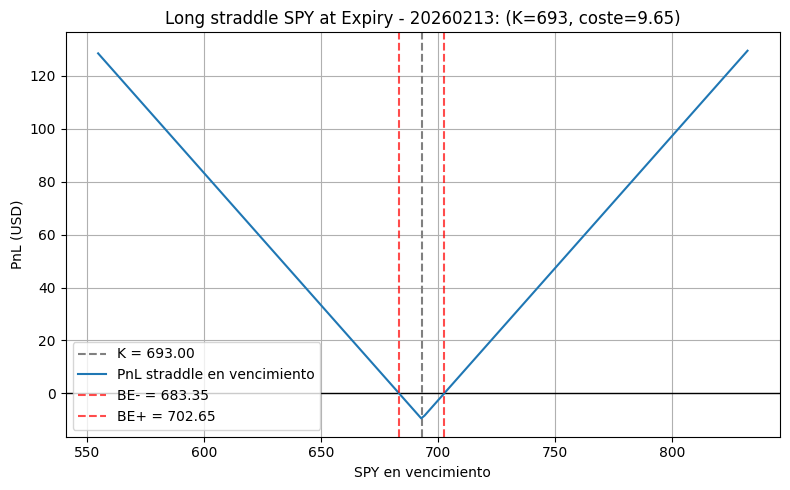

In [36]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 1

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)
    # -------------------------
    # Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    #print("Solicitando precio spot a IBKR...")
    #tickers = ib.reqTickers(spy)
    #if tickers:
    #    S = tickers[0].marketPrice()
    #    # Si el mercado está cerrado, marketPrice() puede fallar,
    #    # a veces es mejor usar close() del día anterior:
    #    if math.isnan(S):
    #        S = tickers[0].close
    #    print(f"SPY spot (S) desde API: {S:.4f}")
    #else:
    #    raise RuntimeError("No se pudo obtener precio de la API.")
#
    # -------------------------
    # Cargar cadena desde CSV
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    # ---------------------------------------------------------
    # Ejecución en TWS
    # ---------------------------------------------------------
    # Creamos los contratos para la ejecución
    c_con = Option("SPY", expiry, K, 'C', 'SMART')
    p_con = Option("SPY", expiry, K, 'P', 'SMART')
    ib.qualifyContracts(c_con, p_con)

    print(f"\nEnviando órdenes para Straddle K={K}...")

    o_call = MarketOrder('BUY', 1, lmtPrice=priceC, tif='DAY')
    o_put  = MarketOrder('BUY', 1, lmtPrice=priceP, tif='DAY')

    trade_c = ib.placeOrder(c_con, o_call)
    trade_p = ib.placeOrder(p_con, o_put)

    # ---------------------------------------------------------
    # 8) VISUALIZACIÓN DEL PAYOFF
    # ---------------------------------------------------------
    STRADDLE_COST = priceC + priceP
    ST_grid = np.linspace(0.8 * S, 1.2 * S, 200)

    # Payoff en vencimiento
    pnl_grid = np.maximum(ST_grid - K, 0) + np.maximum(K - ST_grid, 0) - STRADDLE_COST

    # Dibujar Break-evens
    be_low, be_high = K - STRADDLE_COST, K + STRADDLE_COST

    # ---------------------------------------------------------
    # Check estados de las órdenes
    # ---------------------------------------------------------
    ib.sleep(2)
    print(f"Estado Call: {trade_c.orderStatus.status}")
    print(f"Estado Put:  {trade_p.orderStatus.status}")

    if trade_c.orderStatus.status == 'Cancelled' or trade_p.orderStatus.status == 'Cancelled':
        print("\nATENCIÓN: Las órdenes fueron canceladas. Revisa permisos de 'Opciones' en el Portal de IBKR.")

    # Plot del payoff/PnL en vencimiento
    plt.figure(figsize=(8, 5))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(K, color="gray", linestyle="--", label=f"K = {K:.2f}")

    plt.plot(ST_grid, pnl_grid, label="PnL straddle en vencimiento")

    plt.axvline(be_low, color="red", linestyle="--", alpha=0.7,
                label=f"BE- = {be_low:.2f}")
    plt.axvline(be_high, color="red", linestyle="--", alpha=0.7,
                label=f"BE+ = {be_high:.2f}")

    plt.title(f"Long straddle SPY at Expiry - {expiry}: (K={K:.0f}, coste={STRADDLE_COST:.2f})")
    plt.xlabel("SPY en vencimiento")
    plt.ylabel("PnL (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ib.disconnect()


PUNTO 2: Modificarla para obtener una versión delta-hedged (usando vuestras griegas) con el subyacente.

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.084932
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.89%

--- IV Europea (BS) ---
Call IV: 0.0601
Put  IV: 0.0601

Delta inicial del straddle: 0.0247
Para neutralizar, se deben operar -0.0247 acciones de SPY por cada straddle.


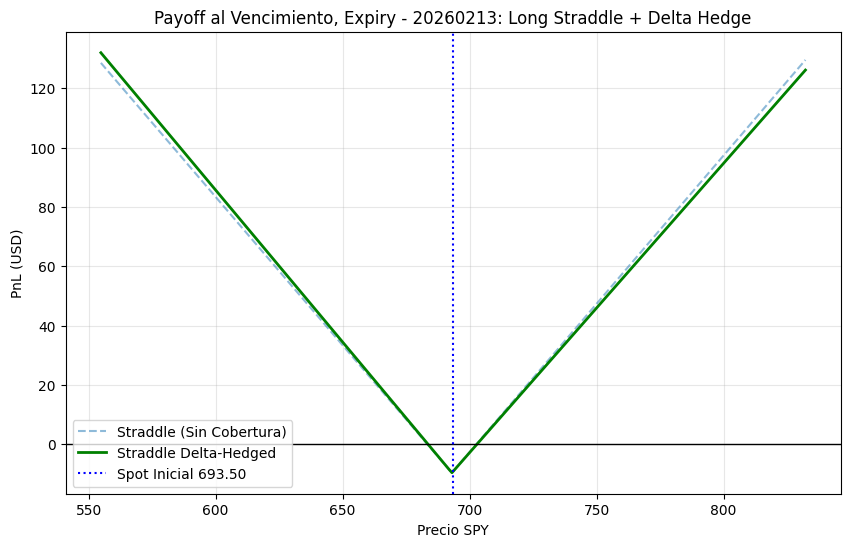

In [22]:
util.startLoop()

if __name__ == "__main__":

    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 5

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)

    # -------------------------
    # Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # Cargar cadena desde CSV
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    # -----------------------------------------
    # Calibración de IV usando tu función americana
    # -----------------------------------------

    sigma_call = implied_vol_bs(priceC, S, K, T, r_calib, q_calib, "C")
    sigma_put  = implied_vol_bs(priceP, S, K, T, r_calib, q_calib, "P")

    print("\n--- IV Europea (BS) ---")
    print(f"Call IV: {sigma_call:.4f}")
    print(f"Put  IV: {sigma_put:.4f}")

    if not (math.isfinite(sigma_call) and math.isfinite(sigma_put)):
        raise RuntimeError("No se pudo calibrar IV europea (Black-Scholes).")

    # -----------------------------------------
    # Perfil del Straddle Delta-Hedged
    # -----------------------------------------
    # Delta inicial del straddle (Suma de deltas de Call y Put)
    gC0 = bs_greeks_manual(S, K, T, r_calib, q_calib, sigma_call, "C")
    gP0 = bs_greeks_manual(S, K, T, r_calib, q_calib, sigma_put,  "P")
    delta_total = gC0["delta"] + gP0["delta"]

    print(f"\nDelta inicial del straddle: {delta_total:.4f}")
    print(f"Para neutralizar, se deben operar {-delta_total:.4f} acciones de SPY por cada straddle.")

    # Rango de precios para dibujar
    S_range = np.linspace(S * 0.8, S * 1.2, 300)

    # Coste total (Prima pagada)
    STRADDLE_COST = priceC + priceP

    # Payoff del straddle puro al vencimiento (incluyendo el coste)
    payoff_straddle_puro = np.maximum(S_range - K, 0) + np.maximum(K - S_range, 0) - STRADDLE_COST

    # Payoff del hedge: Si delta es (+), vendemos SPY. Si es (-), compramos SPY.
    # Ganancia/Pérdida de la cobertura = Cantidad * (Precio_Final - Precio_Inicial)
    # Aquí usamos delta_total porque es la cantidad de acciones a operar (en signo opuesto)
    payoff_hedge = -delta_total * (S_range - S)

    # Payoff Total Delta-Hedged
    payoff_final = payoff_straddle_puro + payoff_hedge

    # -----------------------------------------
    # Ejecucion en TWS del Straddle Delta-Hedged
    # -----------------------------------------
    def ejecutar_estrategia_hedged(ib, call_con, put_con, spy_con, pC, pP, pS, d_total):

        o_call = MarketOrder('BUY', 1, lmtPrice=pC, tif='DAY')
        o_put  = MarketOrder('BUY', 1, lmtPrice=pP, tif='DAY')

        # El hedge: si delta_total es 0.10, vendemos 10 acciones (redondeando)
        # Para este ejemplo usaremos 1 acción para simplificar
        accion_hedge = 'SELL' if d_total > 0 else 'BUY'
        o_hedge = MarketOrder(accion_hedge, 1) # Las acciones suelen permitir Market mejor que las opciones

        print(f"Ejecutando Hedge: {accion_hedge} 1 acción de SPY")
        ib.placeOrder(call_con, o_call)
        ib.placeOrder(put_con, o_put)
        ib.placeOrder(spy_con, o_hedge)

    # Llamada a ejecución
        ejecutar_estrategia_hedged(ib, call_con, put_con, spy, priceC, priceP, S, delta_total)

    # -----------------------------------------
    # Gráfico de Payoff corregido
    # -----------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot(S_range, payoff_straddle_puro, '--', label="Straddle (Sin Cobertura)", alpha=0.5)
    plt.plot(S_range, payoff_final, label="Straddle Delta-Hedged", linewidth=2, color='green')
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(S, color="blue", linestyle=":", label=f"Spot Inicial {S:.2f}")
    plt.title(f"Payoff al Vencimiento, Expiry - {expiry}: Long Straddle + Delta Hedge")
    plt.xlabel("Precio SPY")
    plt.ylabel("PnL (USD)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    ib.disconnect()

La curva de beneficio ya no es una "V" simétrica perfecta respecto al Strike, sino que se inclina para compensar el Delta. Esto reduce la exposición direccional del straddle, pero también puede limitar las ganancias en movimientos fuertes del subyacente.

PUNTO 3: Analizar el P&L histórico de ambas versiones.

Es necesario reconstruir el comportamiento diario de ambas estrategias, long straddle y straddle delta-hedged, desde la fecha de compra hasta el vencimiento, usando los precios diarios del subyacente y las griegas iniciales. En el caso de delta-hedgeg se debe ajustar la posición en el subyacente diariamente.

P&L del straddle sin cubrir, se evalúa en vencimiento.
        PnL_straddle=max(S_T-K,0)+ max (K-S_T,0)-(priceC+priceP)
Donde S_T es el precio de SPY en vencimiento.

P&L del straddle delta-hedged (histórico), simulación diaria:
a) Inicial:
- Compras call y put ATM
- Calculas delta total: Delta =Delta_Call+Delta_Put
- Tomas posición en SPY: -Delta *número_de_contratos
b) Cada día:
- Calculas cambio en precio de SPY: Delta_S_t=S_t-S_t-1
- PnL del hedge: posición_SPY * Delta_S_t
- Acumulas PnL diario
c) En vencimiento:
- Añades payoff de opciones como en el straddle sin cubrir
- Sumas todos los PnL diarios del hedge



Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.082192
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.90%

Delta Call (ATM): 0.51
Delta Put  (ATM): -0.499

Spot final (S_T): 693.5000
Coste total del straddle: 9.6500 USD

--- P&L Straddle sin cubrir en vencimiento ---
Payoff call:   0.5000
Payoff put:    0.0000
Payoff total:  0.5000
PnL straddle:  -9.1500 USD

--- Check rápido evolución histórica ---
         Date   Close  T_remaining  straddle_theo  PnL_straddle_hist
57 2025-12-31  681.92     0.120548      14.939197           5.289197
58 2026-01-02  683.17     0.115068      14.063821           4.413821
59 2026-01-05  687.72     0.106849      11.824914           2.174914
60 2026-01-06  691.81     0.104110      10.897207           1.247207
61 2026-01-07  693.50     0.101370      10.705896           1.055896

--- Check rápid

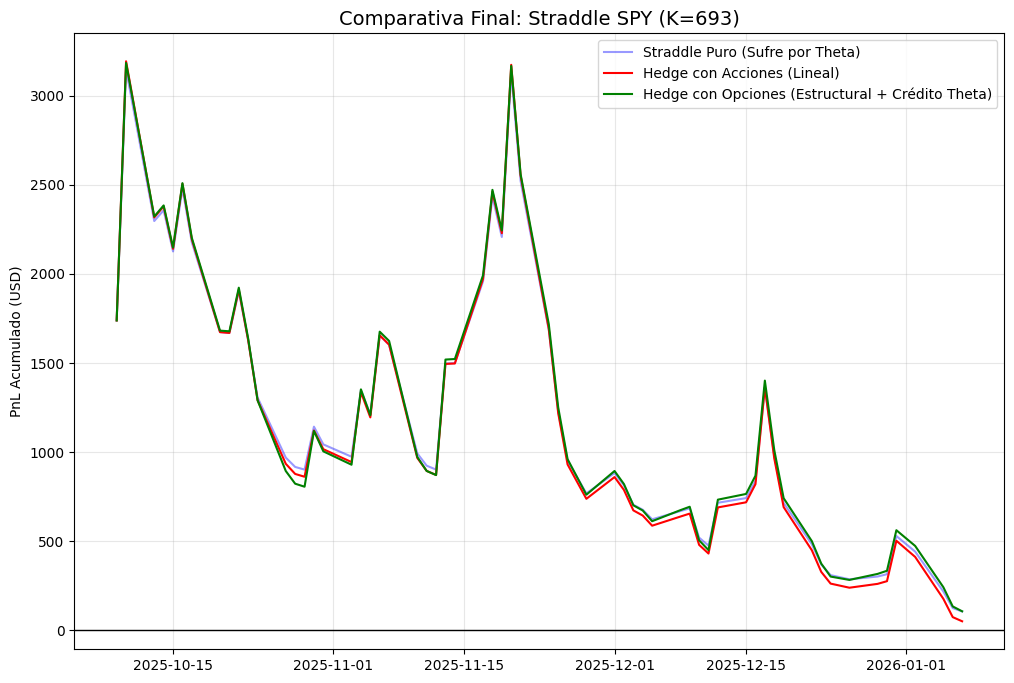


--- Resultado Final ---
PnL Straddle Puro:     $105.59
PnL Delta-Hedge Acciones:    $50.42
PnL Delta-Hedge Opciones:    $106.47


In [44]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 11

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)

    # -------------------------
    # Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    ivC_bs = implied_vol_bisect(priceC, S, K, T, r_calib, q_calib, "C")
    ivP_bs = implied_vol_bisect(priceP, S, K, T, r_calib, q_calib, "P")

    # ------------------------------
    # Delta-Hedged - Obtener deltas
    # ------------------------------

    # Obtener deltas desde tu CSV (fila ATM)
    delta_call = float(row["CALL_DELTA"])
    delta_put  = float(row["PUT_DELTA"])

    print(f"\nDelta Call (ATM): {delta_call}")
    print(f"Delta Put  (ATM): {delta_put}")

    # --------------------------------------------
    # P&L del Straddle sin cubrir en vencimiento
    # --------------------------------------------

    # Precio final del subyacente (último valor del CSV)
    S_T = df_prices["Close"].iloc[-1]
    print(f"\nSpot final (S_T): {S_T:.4f}")

    # Coste total del straddle
    straddle_cost = (priceC + priceP)
    print(f"Coste total del straddle: {straddle_cost:.4f} USD")

    # Payoff en vencimiento
    payoff_call = max(S_T - K, 0)
    payoff_put  = max(K - S_T, 0)
    payoff_total = payoff_call + payoff_put

    # PnL del straddle sin cubrir
    pnl_straddle = payoff_total - straddle_cost

    print("\n--- P&L Straddle sin cubrir en vencimiento ---")
    print(f"Payoff call:   {payoff_call:.4f}")
    print(f"Payoff put:    {payoff_put:.4f}")
    print(f"Payoff total:  {payoff_total:.4f}")
    print(f"PnL straddle:  {pnl_straddle:.4f} USD")


    # ------------------------------------------------------
    # Evolución histórica del long straddle(Black-Scholes)
    # ------------------------------------------------------

    MULT = 100  # Multiplicador de contrato (1 accion = 100 opciones)

    # Nos quedamos solo con las fechas hasta el vencimiento teórico
    expiry_date = datetime.strptime(expiry, "%Y%m%d")
    df_hist = df_prices[df_prices["Date"] <= expiry_date].copy()
    df_hist = df_hist.reset_index(drop=True)

    # Tiempo a vencimiento diario (en años) para cada fecha
    df_hist["T_remaining"] = (expiry_date - df_hist["Date"]).dt.days / 365.0

    # Coste inicial del straddle (referencia para el PnL)
    straddle_cost_real = (priceC + priceP) * MULT

    # Valor teórico diario de la call y la put con IV constante (ivC_bs, ivP_bs)
    df_hist["call_theo"] = df_hist.apply(
        lambda row: bs_price(
            S=row["Close"],
            K=K,
            T=row["T_remaining"],
            r=r_calib,
            q=q_calib,
            sigma=ivC_bs,
            right="C"
        ),
        axis=1
    )

    df_hist["put_theo"] = df_hist.apply(
        lambda row: bs_price(
            S=row["Close"],
            K=K,
            T=row["T_remaining"],
            r=r_calib,
            q=q_calib,
            sigma=ivP_bs,
            right="P"
        ),
        axis=1
    )

    # Valor teórico del straddle cada día
    df_hist["straddle_theo"] = df_hist["call_theo"] + df_hist["put_theo"]

    # PnL histórico del straddle (valor teórico - coste inicial)
    df_hist["PnL_straddle_hist"] = df_hist["straddle_theo"] - straddle_cost

    print("\n--- Check rápido evolución histórica ---")
    print(df_hist[["Date", "Close", "T_remaining", "straddle_theo", "PnL_straddle_hist"]].tail())

    # --------------------------------------------------------
    # Evolución histórica del straddle delta-hedged (clásico, con acciones)
    # --------------------------------------------------------

    # No se recibe prima inicial (el coste de entrada es 0 o el interés del préstamo)
    # El P&L es simplemente: -Delta_inicial * (S_actual - S_inicial)

    S_inicial = df_hist.iloc[0]["Close"]

    # Calcular el P&L de las acciones necesarias para cubrir el delta inicial
    # Usamos MULT=100 para que la escala sea la misma
    df_hist["PnL_hedge_acciones"] = -delta_straddle * (df_hist["Close"] - S_inicial) * 100

    # PnL Total con Acciones = PnL Straddle + PnL Acciones
    df_hist["PnL_delta_hedged_acciones"] = (df_hist["PnL_straddle_hist"] * 100) + df_hist["PnL_hedge_acciones"]

    # --------------------------------------------------------
    # Evolución histórica del straddle delta-hedged (dinámico)
    # --------------------------------------------------------

    # Inicializar variables de estado
    hedge_pos = 0.0      # Acciones en cartera (short delta)
    hedge_pnl_cum = 0.0  # P&L acumulado del hedge
    prev_S = df_hist.iloc[0]["Close"]

    for i, row_hist in df_hist.iterrows():
        S_t = row_hist["Close"]
        T_t = max(row_hist["T_remaining"], 1e-6)

        # Delta del straddle según BS (IV constante)
        gC = bs_greeks_manual(S_t, K, T_t, r_calib, q_calib, ivC_bs, "C")
        gP = bs_greeks_manual(S_t, K, T_t, r_calib, q_calib, ivP_bs, "P")
        delta_unit = gC["delta"] + gP["delta"]

        # Calcular de P&L
        # El P&L de hoy es la posición que traíamos de ayer multiplicada por el cambio de precio
        if i > 0:
            dS = S_t - prev_S
            daily_hedge_pnl = hedge_pos * dS
            hedge_pnl_cum += daily_hedge_pnl

        # Rebalanceo
        # La posición en acciones debe ser la opuesta al delta del straddle
        hedge_pos = -delta_unit * MULT
        prev_S = S_t

        # Guardar resultados
        df_hist.at[i, "Delta_unitario"] = delta_unit
        df_hist.at[i, "Hedge_pos"] = hedge_pos
        df_hist.at[i, "PnL_hedge_cum"] = hedge_pnl_cum
        # PnL total = (PnL Opciones * 100) + PnL Acciones
        df_hist.at[i, "PnL_delta_hedged"] = df_hist.at[i, "PnL_straddle_hist"] + hedge_pnl_cum

    print("\n--- Check rápido delta-hedged (dinámico) ---")
    print(df_hist[["Date", "Close", "Delta_unitario", "Hedge_pos",
               "PnL_hedge_cum", "PnL_straddle_hist", "PnL_delta_hedged"]].tail())

    # ------------------------------------------------
    # Métrica: Volatilidad Realizada vs Implícita
    # ------------------------------------------------

    # Calcular rendimientos logarítmicos diarios
    df_hist['log_ret'] = np.log(df_hist['Close'] / df_hist['Close'].shift(1))

    # Calcular la desviación estándar de los rendimientos
    vol_diaria = df_hist['log_ret'].std()

    # Anualizar (252 días de trading)
    vol_realizada = vol_diaria * np.sqrt(252)

    # Volatilidad Implícita media utilizada en el modelo
    vol_implicita_media = (ivC_bs + ivP_bs) / 2

    print("\n--- Comparativa de Volatilidad ---")
    print(f"Volatilidad Implícita (IV) inicial: {vol_implicita_media:.2%}")
    print(f"Volatilidad Realizada (RV) en el periodo: {vol_realizada:.2%}")

    # Diagnóstico de rentabilidad
    if vol_realizada > vol_implicita_media:
        print("Resultado: RV > IV. El mercado se movió más de lo esperado. El Hedge debería ser rentable.")
    else:
        print("Resultado: RV < IV. El mercado se movió menos de lo esperado. La pérdida por Theta superó a la ganancia por Gamma.")

    # ---------------------------------------------------------
    # Selección de la Opción de Cobertura (Hedge)
    # ---------------------------------------------------------

    # Limpiamos y preparamos el DataFrame de opciones
    df["CALL_DELTA"] = pd.to_numeric(df["CALL_DELTA"], errors='coerce')
    df["EXERCISE"] = pd.to_numeric(df["EXERCISE"], errors='coerce')
    df_clean = df.dropna(subset=["CALL_DELTA"]).copy()

    # Buscamos la opción para neutralizar el delta inicial del Straddle
    target_hedge_delta = abs(delta_straddle)
    df_clean["delta_diff"] = (df_clean["CALL_DELTA"] - target_hedge_delta).abs()
    best_hedge_row = df_clean.loc[df_clean["delta_diff"].idxmin()]

    K_hedge = best_hedge_row["EXERCISE"]
    delta_hedge_opt = best_hedge_row["CALL_DELTA"]

    # Calculamos cuántas opciones vendemos para que Delta Inicial sea 0
    # Importante: Como es un hedge estático con opciones, n_hedge no cambia cada día
    n_hedge = delta_straddle / delta_hedge_opt

    # Estimamos la IV de la opción de cobertura para poder proyectarla históricamente
    # Usamos la ivC_bs del ATM como proxy si no tenemos la específica
    iv_hedge = ivC_bs

    print(f"\n--- CONFIGURACIÓN DEL HEDGE CON OPCIONES ---")
    print(f"Strike elegido para cubrir: {K_hedge}")
    print(f"Contratos a vender (ratio): {n_hedge:.4f}")

    # ---------------------------------------------------------
    # Evolución histórica del Portfolio Hedged (Estructural)
    # ---------------------------------------------------------
    # Reiniciar el cálculo histórico
    df_hist["hedge_opt_theo"] = df_hist.apply(
        lambda row: bs_price(
            S=row["Close"],
            K=K_hedge,
            T=max(row["T_remaining"], 0.00001),
            r=r_calib,
            q=q_calib,
            sigma=iv_hedge,
            right="C"
        ),
        axis=1
    )

    # Coste/Ingreso inicial de la opción de cobertura
    # (Lo que se recibe por vender la opción de hedge)
    price_hedge_init = df_hist.iloc[0]["hedge_opt_theo"]

    # P&L diario de la pata de cobertura (Short Call)
    # P&L = (Precio Inicial - Precio Actual) * cantidad
    df_hist["PnL_hedge_opt"] = (price_hedge_init - df_hist["hedge_opt_theo"]) * n_hedge * MULT

    # PnL TOTAL = PnL Straddle + PnL Opción Cobertura
    df_hist["PnL_delta_hedged_options"] = df_hist["PnL_straddle_hist"] * MULT + df_hist["PnL_hedge_opt"]

    #  ---------------------------------------------------------
    #  Gráfico Final Comparativo (Las 3 Estrategias)
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 8))

    # Straddle Puro
    plt.plot(df_hist["Date"], df_hist["PnL_straddle_hist"] * 100,
             label="Straddle Puro (Sufre por Theta)", alpha=0.4, color='blue', linewidth=1.5)

    # Hedge con Acciones (Clásico)
    plt.plot(df_hist["Date"], df_hist["PnL_delta_hedged_acciones"],
             label="Hedge con Acciones (Lineal)", color='red', linewidth=1.5)

    # Hedge con Opciones (Estructural)
    plt.plot(df_hist["Date"], df_hist["PnL_delta_hedged_options"],
             label="Hedge con Opciones (Estructural + Crédito Theta)", color='green', linewidth=1.5)

    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Comparativa Final: Straddle SPY (K={K})", fontsize=14)
    plt.ylabel("PnL Acumulado (USD)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\n--- Resultado Final ---")
    print(f"PnL Straddle Puro:     ${(df_hist['PnL_straddle_hist'].iloc[-1]*100):.2f}")
    print(f"PnL Delta-Hedge Acciones:    ${df_hist['PnL_delta_hedged_acciones'].iloc[-1]:.2f}")
    print(f"PnL Delta-Hedge Opciones:    ${df_hist['PnL_delta_hedged_options'].iloc[-1]:.2f}")

    ib.disconnect()

PnL straddle sin cubrir se mantiene plano hasta el vencimiento, cuando salta el payoff; en este caso una perdida igual al coste inicial porque el spot final es igual al strike.
PnL del hedge acumulado varía diariamente según los movimientos del subyacente, mostrando ganancias y pérdidas a lo largo del tiempo.


✔️ Si el subyacente se mantuvo cerca del strike
→ el straddle pierde por theta
→ el hedge no compensa
→ el PnL delta‑hedged es negativo
✔️ Si la volatilidad realizada fue menor que la implícita
→ el straddle estaba “caro”
→ no hubo suficiente movimiento para compensar
→ el delta‑hedged pierde
✔️ Si el rebalanceo fue costoso (muchos cambios de delta)
→ cada ajuste de hedge cuesta dinero
→ el PnL acumulado del hedge puede ser negativo
→ el total delta‑hedged baja


PUNTO 4: Simular envío de órdenes: como combo (straddle como una sola orden), y como patas sueltas (call y put por separado) analizando el riesgo de legging.

- Orden combo (straddle)
    - Envías una única orden de compra de straddle (combo call+put).
    - Se ejecuta a un precio único P_{\mathrm{combo}}.
    - No tienes riesgo de quedarte “coja”: o te llenan ambas patas, o nada.
- Patas sueltas (legging)
    - Compras call primero, luego put (o al revés).
    - Entre una y otra, el subyacente se mueve.
    - Te quedas un rato con delta ≠ 0 → riesgo direccional puro.


In [24]:
def simulate_straddle_orders(ib, contract, strike, expiry):
    print("\n--- Iniciando Simulación de Órdenes ---")

    # 1. Definir los contratos de las patas
    call = Option('SPY', expiry, strike, 'C', 'SMART', currency='USD')
    put = Option('SPY', expiry, strike, 'P', 'SMART', currency='USD')

    # Es OBLIGATORIO calificar para obtener los conId antes de armar el Combo
    contracts = ib.qualifyContracts(call, put)
    if not contracts:
        print("Error: No se pudieron calificar los contratos de opciones.")
        return

    # ---------------------------------------------------------
    # Enviar como Combo (Orden Única)
    # ---------------------------------------------------------
    print("\nEnviando Straddle como COMBO (BAG)...")

    straddle_bag = Contract()
    straddle_bag.symbol = 'SPY'
    straddle_bag.secType = 'BAG'
    straddle_bag.currency = 'USD'
    straddle_bag.exchange = 'SMART'

    # Definimos las patas del combo (ratio 1 para un straddle 1:1)
    leg1 = ComboLeg(conId=call.conId, ratio=1, action='BUY', exchange='SMART')
    leg2 = ComboLeg(conId=put.conId, ratio=1, action='BUY', exchange='SMART')
    straddle_bag.comboLegs = [leg1, leg2]

    # En cuenta demo, usamos MarketOrder para ejecución en horario de mercado
    #LimitOrder para poder ejecutar fuera de horario de mercado
    combo_order = LimitOrder(action='BUY', totalQuantity=1)

    # ib.whatIfOrder permite ver el margen sin ejecutar realmente,
    # pero para simular ejecución en Paper usaremos placeOrder
    trade_combo = ib.placeOrder(straddle_bag, combo_order)
    ib.sleep(2)
    print(f"Orden Combo enviada. Status: {trade_combo.orderStatus.status}")

    # ---------------------------------------------------------
    # Enviar por patas (Legging) + Análisis de riesgo
    # ---------------------------------------------------------
    print("\nIniciando ejecución por patas (Legging Risk Analysis)...")

    # Comprar la Call
    print("Ejecutando Pata 1: CALL...")
    call_order = MarketOrder(action='BUY', totalQuantity=1)
    trade_call = ib.placeOrder(call, call_order)

    # Simulamos un pequeño retraso de mercado o latencia de red (2 segundos)
    # Aquí es donde el precio del SPY podría moverse y arruinar el Straddle
    ib.sleep(2)

    # Comprar la Put
    print("Ejecutando Pata 2: PUT...")
    put_order = MarketOrder(action='BUY', totalQuantity=1)
    trade_put = ib.placeOrder(put, put_order)

    # Esperamos a que se llenen
    while not (trade_call.isDone() and trade_put.isDone()):
        ib.sleep(0.5)

    # Análisis de riesgo de legging
    cost_call = trade_call.orderStatus.avgFillPrice
    cost_put = trade_put.orderStatus.avgFillPrice
    total_legs_cost = cost_call + cost_put

    # Obtenemos el precio del combo para comparar
    cost_combo = trade_combo.orderStatus.avgFillPrice

    # En un entorno real, compararíamos contra el Mid-Price del Combo en T0
    print("\n--- RESULTADO DEL ANÁLISIS DE RIESGO ---")
    print(f"Precio ejecución CALL: {cost_call:.2f}")
    print(f"Precio ejecución PUT:  {cost_put:.2f}")
    print(f"Coste Total Legging:   {total_legs_cost:.2f}")
    print(f"Precio Total Combo:    {cost_combo:.2f}")

    # Si el precio del SPY se movió mucho en esos 2 segundos, el coste de la Put habrá cambiado respecto al momento en que compraste la Call.

    if cost_combo > 0:
        diff = total_legs_cost - cost_combo
        print(f"Diferencia (Legging vs Combo): {diff:.2f} USD")
        if diff > 0:
            print("El Legging resultó más caro que el Combo (Slippage negativo.")
        elif diff < 0:
            print("El Legging resultó más barato (mejora el precio).")
        else:
            print("No hubo diferencia entre Legging y Combo.")

    return (trade_combo, trade_call, trade_put)


In [29]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 18

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)
    ib.reqMarketDataType(3)

    # -------------------------
    # Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # Cargar cadena desde CSV
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    #  Strike ATM desde CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    resultado = simulate_straddle_orders(ib, spy, K, expiry)

    # Opcional: Desempaquetar los trades para ver detalles
    if resultado:
        t_combo, t_call, t_put = resultado
        print(f"\nProceso finalizado. ID Combo: {t_combo.order.orderId}")
    ib.disconnect()

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.084932
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.89%

--- Iniciando Simulación de Órdenes ---

Enviando Straddle como COMBO (BAG)...


TypeError: LimitOrder.__init__() missing 1 required positional argument: 'lmtPrice'

PUNTO 5: Ver cómo se puede neutralizar Delta con otra opción y qué implica para Gamma, Vega y Theta.

. El Concepto: Neutralización con Opciones
Cuando compras un Straddle, tienes:

Delta: Cercano a 0 (si es ATM).

Gamma: Positiva (ganas si el precio se mueve).

Vega: Positiva (ganas si sube la volatilidad).

Theta: Negativa (pierdes dinero cada día).

Si el precio se mueve, el Delta deja de ser 0. En lugar de vender acciones, puedes vender una opción (Call o Put) para volver a Delta 0.

| Griega    | Al cubrir con Acciones (Subyacente)                                                            | Al cubrir con otra Opción                                                                         |
|:----------|:-----------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------|
| **Delta** | Se vuelve 0. Neutralizas la dirección del precio inmediatamente.                               | Se vuelve 0. Seleccionas una opción cuyo Delta compense el de tu posición actual.                 |
| **Gamma** | No cambia. Mantienes la curvatura; sigues ganando lo mismo por movimientos bruscos.            | Cambia. Al vender una opción, "vendes" Gamma. Tu curva de beneficios se vuelve más plana.         |
| **Vega**  | No cambia. Tu exposición a los cambios en la Volatilidad Implícita (IV) sigue siendo la misma. | Cambia. Al vender una opción, reduces tu Vega. Eres menos sensible a una caída de volatilidad.    |
| **Theta** | No cambia. El paso del tiempo (time decay) te sigue castigando con la misma intensidad.        | Mejora. Al vender otra opción, cobras prima. Esto compensa parte del coste diario de tu Straddle. |

Simular un escenario donde el precio del SPY se ha movido (creando un desajuste de Delta) y buscaremos en tu data.csv la opción óptima para neutralizarlo.

In [32]:
def plot_hedge_comparison(S_actual, K_straddle, price_straddle, K_hedge, price_hedge, n_contratos, delta_straddle):
    # Generamos un rango de precios para el SPY al vencimiento
    sT = np.linspace(S_actual * 0.8, S_actual * 1.2, 500)

    # 1. P&L Straddle Original (sin cubrir)
    pnl_straddle = (np.abs(sT - K_straddle) - price_straddle)

    # 2. P&L Hedge con Acciones
    # Vendemos 'delta_straddle * 100' acciones (asumiendo multiplicador 100)
    pnl_stock_hedge = pnl_straddle - (delta_straddle * (sT - S_actual))

    # 3. P&L Hedge con Opciones
    # Vendemos 'n_contratos' de la Call elegida
    # P&L de la Call vendida = Prima recibida - Valor intrínseco al vencimiento
    pnl_call_vendida = n_contratos * (price_hedge - np.maximum(sT - K_hedge, 0))
    pnl_option_hedge = pnl_straddle + pnl_call_vendida

    # Graficar
    plt.figure(figsize=(12, 7))
    plt.axhline(0, color='black', lw=1, ls='--')
    plt.axvline(S_actual, color='gray', lw=1, ls=':', label=f'Spot Actual ({S_actual:.2f})')

    plt.plot(sT, pnl_stock_hedge, label='Hedge con Acciones (Lineal)', color='blue', lw=2)
    plt.plot(sT, pnl_option_hedge, label=f'Hedge con Call {K_hedge} (Estructural)', color='orange', lw=2)

    plt.title('Comparativa de Perfil de Riesgo al Vencimiento')
    plt.xlabel('Precio del SPY al Vencimiento')
    plt.ylabel('P&L Estimado')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.084932
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.89%

Griegas Iniciales (Straddle):
Delta: 0.0247 | Gamma: 0.0654
Vega:  1.6051  | Theta: -0.1542

--- COMPARATIVA DE NEUTRALIZACIÓN ---
Opción elegida para Hedge: Call Strike 714
Delta de la opción de cobertura: 0.0240
Cantidad de opciones a vender: 1.03
------------------------------------------------------------
    Metrica  Hedge con Acciones  Hedge con Opcion
Delta Total            0.000000          0.000000
Gamma Total            0.065396          0.060252
 Vega Total            1.605121          1.526918
Theta Total           -0.154191         -0.121264

--- ANÁLISIS ---
1. Reducción de Gamma: 7.9%
2. Cambio en Theta: De -0.1542 a -0.1213


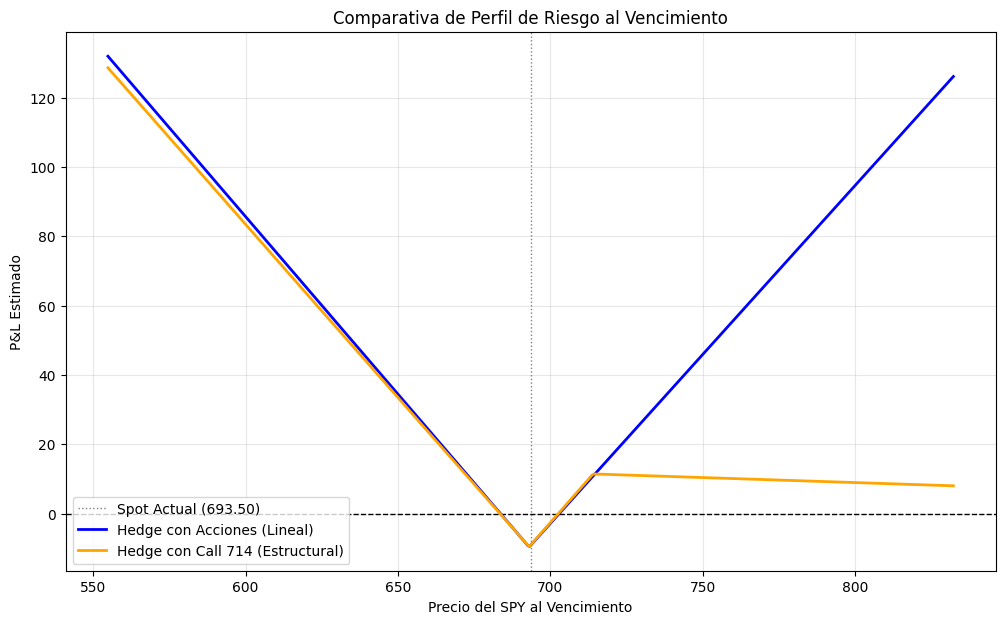

In [34]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 22

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)
    ib.reqMarketDataType(3)
    # -------------------------
    #  Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # 4) Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # 5) Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # 6) Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")
    # ---------------------------------------------------------
    # 7) Análisis de Griegas del Straddle Inicial
    # ---------------------------------------------------------
    # Calculamos IV (puedes usar tus funciones previas)
    ivC = implied_vol_bs(priceC, S, K, T, r_calib, q_calib, "C")
    ivP = implied_vol_bs(priceP, S, K, T, r_calib, q_calib, "P")

    gC = bs_greeks_manual(S, K, T, r_calib, q_calib, ivC, "C")
    gP = bs_greeks_manual(S, K, T, r_calib, q_calib, ivP, "P")

    delta_straddle = gC["delta"] + gP["delta"]
    gamma_straddle = gC["gamma"] + gP["gamma"]
    vega_straddle  = gC["vega"]  + gP["vega"]
    theta_straddle = gC["theta"] + gP["theta"]

    print(f"\nGriegas Iniciales (Straddle):")
    print(f"Delta: {delta_straddle:.4f} | Gamma: {gamma_straddle:.4f}")
    print(f"Vega:  {vega_straddle:.4f}  | Theta: {theta_straddle:.4f}")

    # Limpieza de datos: Convertimos a numérico las columnas necesarias
    # El parámetro errors='coerce' es vital para ignorar los "x 0.01" y celdas vacías
    df["CALL_DELTA"] = pd.to_numeric(df["CALL_DELTA"], errors='coerce')
    df["EXERCISE"] = pd.to_numeric(df["EXERCISE"], errors='coerce')
    df["CALL_GAMMA"] = pd.to_numeric(df["CALL_GAMMA"], errors='coerce')
    df["CALL_VEGA"] = pd.to_numeric(df["CALL_VEGA"], errors='coerce')
    df["CALL_THETA"] = pd.to_numeric(df["CALL_THETA"], errors='coerce')

    # Filtramos para quedarnos solo con opciones que tengan datos válidos de Delta
    df_clean = df.dropna(subset=["CALL_DELTA"]).copy()

    # Si tu delta_straddle es positivo (ej: 0.15), necesitas vender Delta
    # Buscamos la opción cuyo delta sea más cercano al delta que queremos compensar
    target_hedge_delta = abs(delta_straddle)

    df_clean["delta_diff"] = (df_clean["CALL_DELTA"] - target_hedge_delta).abs()
    best_hedge_row = df_clean.loc[df_clean["delta_diff"].idxmin()]

    K_hedge = best_hedge_row["EXERCISE"]
    delta_hedge_opt = best_hedge_row["CALL_DELTA"]

    # Calculamos cuántos contratos necesitamos vender para neutralizar
    # n = Delta a cubrir / Delta de la opción de cobertura
    n_contratos = delta_straddle / delta_hedge_opt

    # ---------------------------------------------------------
    # 9) Comparativa de Impacto
    # ---------------------------------------------------------
    # Usamos los datos directamente de tu CSV para el hedge
    gamma_h = best_hedge_row["CALL_GAMMA"]
    vega_h  = best_hedge_row["CALL_VEGA"]
    theta_h = best_hedge_row["CALL_THETA"]

    print(f"\n--- COMPARATIVA DE NEUTRALIZACIÓN ---")
    print(f"Opción elegida para Hedge: Call Strike {K_hedge}")
    print(f"Delta de la opción de cobertura: {delta_hedge_opt:.4f}")
    print(f"Cantidad de opciones a vender: {n_contratos:.2f}")
    print("-" * 60)

    data_res = {
        "Metrica": ["Delta Total", "Gamma Total", "Vega Total", "Theta Total"],
        "Hedge con Acciones": [0.0, gamma_straddle, vega_straddle, theta_straddle],
        "Hedge con Opcion": [
            delta_straddle - (n_contratos * delta_hedge_opt),
            gamma_straddle - (n_contratos * gamma_h),
            vega_straddle - (n_contratos * vega_h),
            theta_straddle - (n_contratos * theta_h)
        ]
    }

    df_res = pd.DataFrame(data_res)
    print(df_res.to_string(index=False))

    print("\n--- ANÁLISIS ---")
    print(f"1. Reducción de Gamma: {((n_contratos * gamma_h) / gamma_straddle):.1%}")
    print(f"2. Cambio en Theta: De {theta_straddle:.4f} a {data_res['Hedge con Opcion'][3]:.4f}")

    # Extraemos los precios necesarios para el P&L
    precio_straddle_total = priceC + priceP
    precio_opt_hedge = best_hedge_row["call_mid"] if "call_mid" in best_hedge_row else 0

    plot_hedge_comparison(S, K, precio_straddle_total, K_hedge, precio_opt_hedge, n_contratos, delta_straddle)

    ib.disconnect()

PUNTO 6: Reflexión: ¿qué habría cambiado usando SPX en lugar de SPY?